# SJ Detached ADUs

* Geocode detached ADU list (1,142 records)
*

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm
import geopandas as gpd
import pandas as pd
import os

tqdm.pandas()

In [2]:
# Paths
OAK_FP = '/oak/stanford/groups/deho/building_compliance/'
OUTPUT_FP = os.path.join(OAK_FP, 'outputs', 'Population-Estimates', 'outputs')
INPUT_FP = os.path.join(OAK_FP, 'outputs', 'Population-Estimates', 'inputs')

In [5]:
# SJ Residential parcels
sj_parcels_cbgs = gpd.read_file(os.path.join(OUTPUT_FP, 'sj-parcels-res-cbgs'))

# Assessor parcel data
assessor_parcels = gpd.read_file(os.path.join(INPUT_FP, 'AssessorData', 'assessor_scc_parcels.geojson'))
sj_assessor_parcels = assessor_parcels.loc[assessor_parcels['SITUS_CITY'] == 'SAN JOSE'].copy()
del assessor_parcels

# Detached ADU list (issued on or after Jan 1, 2015 - December, 2022)
adu_list = pd.read_csv(os.path.join(INPUT_FP, 'IssuedADUs', 'Adu_Detach.csv'))
adu_list['DATE'] = pd.to_datetime(adu_list['ISSUEDATE'])

In [6]:
# Keep only parcel data
sj_assessor_parcels = sj_assessor_parcels.loc[sj_assessor_parcels['FEATURE'] == 'PAR']
sj_assessor_parcels = sj_assessor_parcels[[
    'OBJECTID', 'APN', 'SITUS_HOUS', 'SITUS_STRE', 'SITUS_HO_1', 'SITUS_ST_1', 'SITUS_ST_2', 'SITUS_UNIT', 
    'SITUS_CITY', 'SITUS_STAT', 'SITUS_ZIP_', 'geometry']].copy()

In [7]:
# Check for dupilcate addresses in ADU list
N_ADUs = len(adu_list)
print('[INFO] Number of ADUs: {}'.format(N_ADUs))
print('[INFO] Number of duplicated ADU addresses: {}'.format(adu_list.duplicated(['PROP_ADDRESS']).sum()))
print('[INFO] Number of duplicated folder numbers: {}'.format(adu_list.duplicated(['FOLDERNUMBER']).sum()))

[INFO] Number of ADUs: 1142
[INFO] Number of duplicated ADU addresses: 0
[INFO] Number of duplicated folder numbers: 0


[INFO] Annual number of detached ADU permits issued


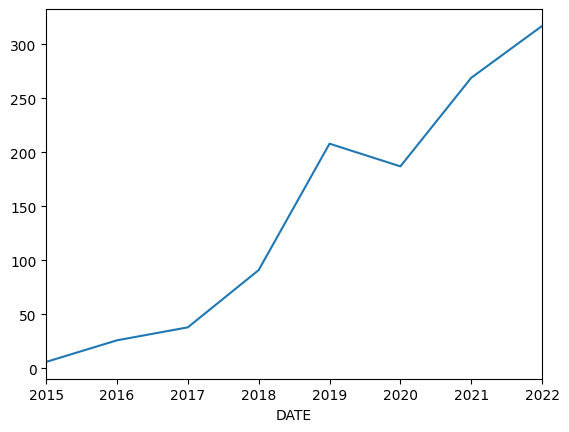

In [8]:
print('[INFO] Annual number of detached ADU permits issued')
df = adu_list.set_index('DATE').resample('Y')['FOLDERNUMBER'].count()
df.plot()
plt.show()

## 1. Geocode detached ADUs

In [9]:
# Remove trailing 2 and 3
adu_list['CLEAN_ADDRESS'] = adu_list['PROP_ADDRESS'].apply(
    lambda address: address.rstrip())

adu_list['CLEAN_ADDRESS'] = adu_list['CLEAN_ADDRESS'].apply(
    lambda address: address[:-2] if address[-2:] in [' 2', ' 3'] else address)

# Note that properties ending in 2, 3 that are duplicated point to the same parcel APN

In [10]:
# Configure address
sj_assessor_parcels_m = sj_assessor_parcels.copy()
sj_assessor_parcels_m['ADDRESS'] = sj_assessor_parcels_m.progress_apply(
    lambda row: '{}  {} {}'.format(
        str(row['SITUS_HOUS'] or ''),
        str(row['SITUS_ST_1'] or ''), 
        str(row['SITUS_ST_2'] or '')), 
    axis=1)

100%|██████████| 228276/228276 [00:03<00:00, 75475.40it/s]


In [11]:
# Address duplicates matching to different APNs
# We allow addresses to match multiple APNs as we have no way of knowing the exact address for these
print('[INFO] Duplicated addresses: {}'.format(sj_assessor_parcels_m.duplicated(['ADDRESS']).sum()))

# Merge
merged = pd.merge(
    adu_list, sj_assessor_parcels_m[['APN', 'ADDRESS']], 
    how='left', left_on='CLEAN_ADDRESS', right_on='ADDRESS')

[INFO] Duplicated addresses: 6816


Handle the following cases and concatenate back together out of the 1,142 cases
* Non-missing, unique APNs (1,090 cases)
* Multiple APNs (24 cases)
* Missing APNs (28 cases)

In [12]:
# Non-missing, unique APNs
unique_nonmis = merged.loc[
    (~merged.duplicated(['FOLDERNUMBER'], keep=False)) & (~merged['APN'].isna())]

In [22]:
# Compute centroids so we can get parcel locations
sj_parcels_cbgs_cent = sj_parcels_cbgs.to_crs('EPSG:26910').copy()
sj_parcels_cbgs_cent['centroid'] = sj_parcels_cbgs_cent.geometry.centroid
sj_parcels_cbgs_cent = gpd.GeoDataFrame(sj_parcels_cbgs_cent, geometry='centroid', crs='EPSG:26910')
sj_parcels_cbgs_cent = sj_parcels_cbgs_cent.to_crs('EPSG:4326')

sj_parcels_cbgs_cent['cent'] = sj_parcels_cbgs_cent['centroid'].apply(
    lambda p: '{}, {}'.format(list(p.coords)[0][1], list(p.coords)[0][0]))

In [113]:
# ADUs with multiple APN matches
multiple = merged.loc[merged['FOLDERNUMBER'].isin(
    merged.loc[merged.duplicated('FOLDERNUMBER')]['FOLDERNUMBER'])].sort_values('FOLDERNUMBER')

# Check APNs for detached buildings
multiple = multiple.groupby('FOLDERNUMBER')['APN'].apply(' '.join).reset_index()
multiple.iloc[10]

FOLDERNUMBER            20-110656
APN             46747027 24943081
Name: 10, dtype: object

In [114]:
sj_parcels_cbgs_cent.loc[sj_parcels_cbgs_cent['APN'].isin(['46747027', '24943081'])]

,APN,GEOID,geometry,centroid,cent
49944,24943081,060855011011,"POLYGON ((597936.623 4133696.681, 597944.346 4...",POINT (-121.89447 37.34464),"37.344643069224645, -121.89447017015496"
92009,46747027,060855009012,"POLYGON ((598908.641 4132103.370, 598914.022 4...",POINT (-121.88371 37.33020),"37.3302018754484, -121.88371113959083"


In [115]:
adu_list.loc[adu_list['FOLDERNUMBER'] == '20-110656']

,FOLDERNUMBER,ISSUEDATE,FOLDERRSN,SUBDESC,WORKDESC,PROP_ADDRESS,DATE,CLEAN_ADDRESS
447,20-110656,07/08/2020 09:45:10,"1,858,773",2nd Unit Added,New Construction,453 3RD ST 2,2020-07-08 09:45:10,453 3RD ST


In [127]:
multiple_cases = {
    '17-026160': '24923039',
    '18-101972': '48116046',
    '18-135702': '46737082', 
    '18-138469': '24901009', 
    '18-139413': '24931030',
    '19-100899': '24931033',
    '19-130667': '47222029', 
    '19-144077': None, # both already built 
    '19-154795': '47223028', 
    '20-108480': '24947022',
    '20-110656': None, # both already built 
    '20-121936': '23506017', # already built 
    '20-140394': None, # both already built 
    '20-145382': '47219062', 
    '21-010446': '47222006',
    '21-011572': '47230014', 
    '21-012800': '24954058', 
    '21-020836': '46703097', 
    '21-024523': '24952044', # being built
    '21-026034': '26108066', # already built
    '21-033589': '24942024', # already built 
    '21-053632': '24957014', 
    '21-060566': None, # both already built 
    '22-661460': None, # both already built
}

# Check that all APNs stem from potential APNs
for folder, apn in multiple_cases.items():
    row = multiple.loc[multiple['FOLDERNUMBER'] == folder].iloc[0]
    if not pd.isnull(apn) and apn not in row['APN'].split(' '):
        print('[ERROR] {}'.format(apn))
multiple_cases = pd.DataFrame({'FOLDERNUMBER': multiple_cases.keys(), 'APN': multiple_cases.values()})

In [143]:
# Handle missing cases
print('Missing: {}'.format(len(merged.loc[merged['APN'].isna()])))
merged.loc[merged['APN'].isna()]

missing_cases = {
 '1025  HAPPY VALLEY AV ': '38141082',
 '15110  SAMARITAN DR ': '42108045',
 '1761  PARKMOOR AV ': '27726015',
 '1469  RUE AVATI  ': '24525032',
 '2696  PLAZA BANDERAS  ': '58902031',
 '6103  CORTE DE LA REINA  ': '57531011',
 '454  21ST ST ': '24963047', ### MULTIPLE but this one has an ADU construction
 '344  JEROME ST 2': '26440130',
 '271  MCDONALD AV 2': '48103045',
 '273  MCDONALD AV 2': '48103045',
 '724  HARRISON ST 2': '26443028',
 '453  6TH ST 2': '24947023', # MULTIPLE but only North has an ADU construction
 '1074  MACHADO LN 2': '61233013',
 '2041  CULLY PL 2': '41452001',
 '2045  CULLY PL 2': '41452002',
 '2049  CULLY PL 2': '41452003',
 '2053  CULLY PL 2': '41452004',
 '2057  CULLY PL 2': '41452005',
 '2061  CULLY PL 2': '41452006',
 '2214  ROYAL TREE CL 2': '24410033',
 '2785  ALMADEN RD 2': '43946076',
 '2743  ALMADEN RD 2': '43946074',
 '1053  COLEMAN RD 1107': None, # Assessor maps to 69402031? UNSURE -- these are apartments
 '1035  COLEMAN RD 7125': None, # Assessor maps to  69402031 -- these are apartments
 '115  MUIRFIELD DR 3': '48441149',
 '1960  QUITO RD 2': '40332122',
 '5187  WARWICK RD 2': None, # Can't find in Google Maps nor assessor data
 '5161  WARWICK RD 2': None # Can't find in Google Maps nor assessor data
}

missing_cases = pd.DataFrame({'PROP_ADDRESS': missing_cases.keys(), 'APN': missing_cases.values()})
missing_cases = pd.merge(missing_cases, adu_list[['FOLDERNUMBER', 'PROP_ADDRESS']], validate='one_to_one')

Missing: 28


In [144]:
# Concatenate and generate final list
final_list = pd.concat([
    unique_nonmis[['FOLDERNUMBER', 'APN']], 
    multiple_cases[['FOLDERNUMBER', 'APN']], 
    missing_cases[['FOLDERNUMBER', 'APN']]
    ])

final_list = pd.merge(
    final_list, adu_list[['FOLDERNUMBER', 'ISSUEDATE', 'SUBDESC', 'WORKDESC', 'PROP_ADDRESS', 'DATE']], 
    how='left', on='FOLDERNUMBER', validate='one_to_one'
)

In [147]:
test_cases = {
    '137  CEDAR LN 2': '48416116', 
    '971  PACIFIC AV 2': '26141068',
    '2956  DRIFTWOOD DR 2': '27926026', 
    '1690  SANTA LUCIA DR 2': '28414029', 
    '5488  ESCOVER LN 2': '56904057',
    '6162  MERIDIAN AV ': '57713060', 
    '912  MISSION ST ': '24919087', # east? 
    '5209  HALIFAX DR 2': '40338022',
    '732  VONNA CT 2': '68716064',
    '1485  RICHARDS AV ': '42939019', 
    '2718  AIDA AV 2': '67018039',
    '14155  CANDLER AV 2': '64703047', 
    '3289  INGERSOLL DR 3': '65445032',
    '2179  LAKEWOOD DR ': '09204051', 
    '1303  FLORA AV ': '30723014',
    '470  MAPLEWOOD AV ': '30341002',
    '6948  HOWDEN CT 2': '70638027',
    '950  THELMA WY 2': '47744005'
}

test_pass = 0
for address, apn in test_cases.items():
    row = final_list.loc[final_list['PROP_ADDRESS'] == address]
    if len(row) > 2:
        print('[ERR]')
        continue
    
    row = row.iloc[0]
    geo_apn = row['APN']
    if geo_apn == apn:
        test_pass += 1
    else:
        print('[ERR] {} {} {}'.format(address, apn, geo_apn))
print('[INFO] Pass {}/{} cases'.format(test_pass, len(test_cases)))

[INFO] Pass 18/18 cases


In [148]:
# Save geocoded version
final_list.to_csv(os.path.join(OUTPUT_FP, 'IssuedADUs', 'Adu_Detach.csv'), index=False)
final_list.head()

,FOLDERNUMBER,APN,ISSUEDATE,SUBDESC,WORKDESC,PROP_ADDRESS,DATE
0,14-044732,49709034,01/12/2015 16:28:45,2nd Unit Added,New Construction,13112 BROWN AV,2015-01-12 16:28:45
1,14-021975,49146040,03/30/2015 14:08:16,2nd Unit Added,New Construction,2800 GLEN SHARON WY,2015-03-30 14:08:16
2,14-033640,43917022,04/10/2015 10:18:39,2nd Unit Added,New Construction,999 FRANQUETTE AV,2015-04-10 10:18:39
3,14-012614,58351012,07/09/2015 16:09:49,2nd Unit Added,New Construction,1188 ALMADEN OAKS LN,2015-07-09 16:09:49
4,15-009106,28823016,10/19/2015 14:56:10,2nd Unit Added,New Construction,1979 PATIO DR,2015-10-19 14:56:10


In [149]:
final_list.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1142 entries, 0 to 1141
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   FOLDERNUMBER  1142 non-null   object        
 1   APN           1133 non-null   object        
 2   ISSUEDATE     1142 non-null   object        
 3   SUBDESC       1142 non-null   object        
 4   WORKDESC      1142 non-null   object        
 5   PROP_ADDRESS  1142 non-null   object        
 6   DATE          1142 non-null   datetime64[ns]
dtypes: datetime64[ns](1), object(6)
memory usage: 71.4+ KB
